# Convertes the output of emulate_bitw into a standard fits catalogue  

In [1]:
from matplotlib import pyplot as plt
from astropy.io import (fits, ascii)
import numpy as np
from numpy.random import default_rng
import pickle

## Reading the bitweights (fortran binary)

In [37]:
nwe = 9

from scipy.io import FortranFile

#namin_fbw = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/emulate_bitw_v1.1/out/FAemu_m0_N_ELG_llen0.02_truent_antico_deco0.1_beta0_cfc_nbits279_wemu_unformatted.dat' 
#namin_fbw = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/EZOutputs_TrainedOnData/EZ_FAemu_m1_B_QSO_llen0.02_truent_cfc_antico_deco0.1_beta0_nbits279_wemu_unformatted.dat'
#namin_fbw = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/old_outputs/EZoutprepped_new/EZ_FAemu_m1_N_QSO_llen0.02_truent_cfc_antico_deco0.1_beta0_nbits279_wemu_unformatted.dat'
#namin_fbw = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/EZOutputs_TrainedOnData/EZ_FAemu_m1_B_QSO_llen0.02_truent_cfc_antico_deco0.1_beta0_nbits279_wemu_unformatted.dat'
namin_fbw = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/EZOutputs_TrainedOnData/EZ_FAemu_m1_B_LRG_llen0.02_truent_cfc_antico_deco0.1_beta0_nbits279_wemu_unformatted.dat'

f = FortranFile(namin_fbw, 'r')
we = f.read_ints(dtype='int32')
#print(np.shape(we))

npart = np.shape(we)[0]//nwe
print('npart =', npart)
we = we.reshape((nwe, npart)).T;
print(np.shape(we))

print(we)

npart = 4818724
(4818724, 9)
[[1898812711 1614639191 1729246472 ...  202428962  615225057  293933099]
 [ 437821954 1258797440    1346558 ...  306827297 1401358337 1636896266]
 [1119105515 1007975088  539038304 ...  713146487 1346538828  118452953]
 ...
 [ 108168244 1490177739      34304 ... 1412637760  344658714   12735200]
 [ 875909523 1946239242  579851878 ... 1113231745 1577623186  572099603]
 [1145114969  537143584  573129216 ...  154194024 1638096898  622625304]]


# Fuctions to pack-unpack bitweights in different formats

In [38]:
def pack_bitweights(array):
    """
    Creates an array of bitwise weights stored as 64-bit signed integers
    Input: a 2D boolean array of shape (Ngal, Nreal), where Ngal is the total number 
           of target galaxies, and Nreal is the number of fibre assignment realizations.
    Output: returns a 2D array of 64-bit signed integers. 
    """
    Nbits=64
    dtype=np.int64
    Ngal, Nreal = array.shape           # total number of realizations and number of target galaxies
    Nout = (Nreal + Nbits - 1) // Nbits # number of output columns
    # intermediate arrays
    bitw8 = np.zeros((Ngal, 8), dtype="i")   # array of individual bits of 8 realizations
    bitweights = np.zeros(Ngal, dtype=dtype) # array of 64-bit integers
    # array to store final output
    output_array = np.zeros((Ngal, Nout), dtype=dtype)
    idx_out = 0 # initial column in output_array
    # loop through realizations to build bitwise weights
    for i in range(Nreal):
        bitw8[array[:,i], i%8] = 1
        arr = np.array(np.packbits(bitw8[:,::-1]), dtype=dtype)
        bitweights = np.bitwise_or(bitweights, np.left_shift(arr, 8*((i%Nbits)//8)))
        #print(np.binary_repr(bitweights[0]), bitweights[0])
        if (i+1)%Nbits == 0 or i+1 == Nreal:
            output_array[:,idx_out] = bitweights
            bitweights[:] = 0
            idx_out += 1
        if (i+1)%8 == 0:
            bitw8[:] = 0
    return output_array

In [39]:
def unpack_bitweights(we):
    Nbits = 64
    Ngal, Nwe = np.shape(we)
    Nreal = Nbits*Nwe
    print('Nbits, Nwe = ',Nbits,Nwe)
    print('Nreal = ',Nreal)
    print('Ngal = ',Ngal)
    true8=[np.uint8(255) for n in range(0, Ngal)]
    array_bool = np.zeros((Ngal,Nreal), dtype=bool)
    for j in range(Nwe):
        lg = np.zeros((Ngal, Nbits), dtype=bool)
        for i in range(Nbits//8):
            chunk8 = np.uint8(np.bitwise_and(np.right_shift(we[:,j],8*i), true8))
            lg[:,Nbits-8*(i+1):Nbits-i*8] = np.reshape(np.unpackbits(chunk8), (Ngal, 8))
        array_bool[:,j*Nbits:(j+1)*Nbits] = lg[:,::-1]
    return array_bool

In [40]:
def pack_bitweights_BP2017(array):
    Nbits = 31
    Nwe = np.shape(array)[1]//Nbits
    Nreal = Nwe*Nbits
    Ngal = np.shape(array)[0]
    print('Nbits, Nwe = ',Nbits,Nwe)
    print('Nreal = ',Nreal)
    print('Ngal = ',Ngal)
    we = np.zeros((Ngal, Nwe), dtype=np.int32)
    for i in range(Nreal):
        k = i % Nbits
        m = i // Nbits
        we[array[:,i], m] += 2**k        
    return we

In [41]:
def unpack_bitweights_BP2017(we):
    
    Nbits = 31
    Ngal, Nwe = np.shape(we)
    Nreal = Nbits*Nwe
    print('Nbits, Nwe = ',Nbits,Nwe)
    print('Nreal = ',Nreal)
    print('Ngal = ',Ngal)    
    
    array_bool = np.zeros((Ngal, Nreal), dtype=bool)
    for i in range(0, Ngal):
        for j in range(0, Nwe):
            lg = bin(we[i][j])[2:]
            lg = lg[::-1]+(Nbits-len(lg))*'0'
            lg = np.array([int(digit) for digit in lg], dtype=bool)
            array_bool[i,j*Nbits:(j+1)*Nbits] = lg
      
    return array_bool

## Unpacking bitweights

In [42]:
bool_tot = unpack_bitweights_BP2017(we)

Nbits, Nwe =  31 9
Nreal =  279
Ngal =  4818724


In [54]:
bool_tot

array([[ True,  True,  True, ...,  True, False, False],
       [False,  True, False, ..., False,  True,  True],
       [ True,  True, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False],
       [ True, False, False, ..., False,  True, False]])

In [43]:
namout_bool = 'out/emucat_out/ezm1_LRG_B_bool_tot_datatrain.bin'

### write bool array (just for convenience, not to have to recompute it)

In [44]:
bool_file = open(namout_bool, 'wb')
pickle.dump(bool_tot, bool_file)
bool_file.close()

### read bool array (just for convenience, in case you have already computed it)

In [55]:
namin_bool = namout_bool

bool_file = open(namin_bool, 'rb')
bool_tot = pickle.load(bool_file)
bool_file.close()

#print(bool_tot)

In [56]:
#bitw_test = pack_bitweights_BP2017(bool_tot)

## Randomly extracting "observed" sample and alt-realisations

In [57]:
rng = default_rng()
nsmpls_out = 64*4
nsmpls_in = 31*9 
id_ran = rng.choice(nsmpls_in, size=nsmpls_out+1, replace=False)
print(id_ran)

[ 84 160  97  21 251 147  22  19  39 121 199 274 273 166 110 172 184 232
  76  52 105   4  13 178 277  88 115  92   2  99  10 175 154 157  83 155
  41  68  28  55 146 239 261 191 186 109   1 112 168 244 214 117 238 169
  35 258 120  79  15 163  90 171  50  65  63 124 104  71 271  54  64 250
 206 247  45   5 118 165  72  61  32  27  38   8 176 106  57  53  82 111
  51 237 219 150 228 267 138 253 194  24 263 221 208 122 156 255 248  40
  91 135  89 215  20 236 243  46 278 235 216  87 145 265 269 144 218 217
 167 225  70 211 180 101  42 234 249  96 152 193 195  74 128 136 188 140
 242 229 231 116  12 149  11  93   3 132 143 151 241  36 210 103 127 189
 182 164 240 276  56 190 183 209 260 159 185 275 257 161  85 227 213 187
  23  98 125 148 141 203  75  78  37  81 226 264 162  95  30 201 158  66
 207 220 179 134 252 254 102  17 129  49  33  69 126 272 177 108  59 173
 142 114 202 113 233  26  60 170  47 270 119 153  29 200  73 224  16 130
 198 139 137 174 262   0 222 197  44 196  14 259  2

In [58]:
msk_obs = bool_tot[:,id_ran[0]]
id_msk_obs = np.where(msk_obs)
print(msk_obs)
print(np.sum(msk_obs))
print(id_msk_obs)
print(np.shape(id_msk_obs))

[False False False ... False False False]
2742598
(array([      4,       5,       6, ..., 4818712, 4818713, 4818714]),)
(1, 2742598)


In [59]:
bool_out = bool_tot[:,id_ran[1:]]
print(np.shape(bool_out))

(4818724, 256)


## Packing bitweights with the desired format

In [60]:
we_out = pack_bitweights(bool_out)
#we_out = pack_bitweights_BP2017(bool_out)

print(we_out)
print(np.shape(we_out))

[[ 8338595168177700956 -5745720088627710328  7707715169468110452
   2901100844497035399]
 [-3296004975781453352 -8062427805523951314  4643246572125339705
   8480843473057431836]
 [  298432846587567116  4683971490196360967  4922266468429100127
  -6871792564485855545]
 ...
 [  469007719275168292  5270202572198831772  2981429167184236760
  -1250808803890162592]
 [-8843459208950364028  3198552143690001319  8431165142058503461
   6023651125555759749]
 [    6970912319644859   630530371544680836 -7781621432344242022
  -9204720401696536018]]
(4818724, 4)


## Computing IIP weights

In [61]:
npart_out = np.shape(we_out)[0]
print('npart_out =', npart_out)

nbits_out = np.shape(we_out)[1] * 64
#nbits_out = np.shape(we_out)[1] * 31
print('nbits_out =', nbits_out)

wiip = np.zeros(npart, dtype=float)
#wiip[id_msk_obs] = nbits_out / np.sum(bool_out[id_msk], axis=1)
wiip[id_msk_obs] = (nbits_out + 1) / (np.sum(bool_out[id_msk_obs], axis=1) + 1)

npart_out = 4818724
nbits_out = 256


[0. 0. 0. ... 0. 0. 0.]


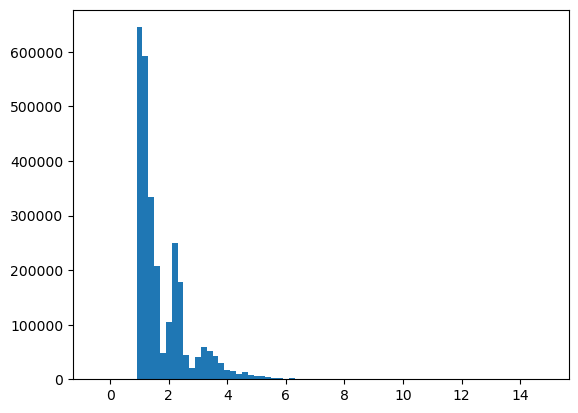

In [62]:
print(wiip)
plt.hist(wiip[id_msk_obs], np.arange(-0.5,15,0.2));

In [63]:
wiip[0:11]

array([0.        , 0.        , 0.        , 0.        , 1.57668712,
       1.07083333, 3.77941176, 0.        , 0.        , 2.4245283 ,
       0.        ])

## Reading galaxy positions and other quantities of interest

In [25]:
namin_ref = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/fof_v1.0/in/prepped_QSO_EZmock_forFAemu_m1.dat'

data = ascii.read(namin_ref, format='no_header')
RA = np.array(data["col1"])
dec = np.array(data["col2"])
#truez = np.array(data["col3"])
rsdz = np.array(data["col4"])
#DESI_target = np.array(data["col5"])
#rchmsk = np.array(data["col6"])
#selmsk = np.array(data["col7"])
ntile = np.array(data["col8"])
#gcap = np.array(data["col9"])
#ntgal = np.array(data["col10"])
#comp = np.array(data["col11"])
targetid = np.array(data["col10"])

## Writing output

In [26]:
#targetid = np.arange(1, len(RA)+1, dtype=int)

namout_tot = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/emucat_out/catalogs/EZ_clustering_cat_FAemu_m1_B_QSO_llen0.02_truent_cfc_antico_deco0.1_beta0_mock0train.fits'

col1 = fits.Column(name='TARGETID', array=targetid[id_msk_obs], format='K')
col2 = fits.Column(name='RA', array=RA[id_msk_obs], format='E')
col3 = fits.Column(name='DEC', array=dec[id_msk_obs], format='E')
col4 = fits.Column(name='RSDZ', array=rsdz[id_msk_obs], format='E')
col5 = fits.Column(name='NTILE', array=ntile[id_msk_obs], format='K')
col6 = fits.Column(name='WEIGHT_IIP', array=wiip[id_msk_obs], format='E')
col7 = fits.Column(name='BITWEIGHT', array=we_out[id_msk_obs], dim='4', format='4K')
#col8 = fits.Column(name='DESI_TARGET', array=DESI_target[id_msk_obs], format='K')
#col9 = fits.Column(name='TRUEZ', array=truez[id_msk_obs], format='E')
#col10 = fits.Column(name='RCH_MASK', array=rchmsk[id_msk_obs], format='L')
#col11 = fits.Column(name='SEL_MASK', array=selmsk[id_msk_obs], format='L')
#col12 = fits.Column(name='GAL_CAP', array=gcap[id_msk_obs], format='A')

tbl = fits.BinTableHDU.from_columns([col1, col2, col3, col4, col5, col6, col7])

tbl.writeto(namout_tot, overwrite=True)

In [4]:
#namout_tot = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/EZ_corr_clustering_cat_FAemu_m1_N_LRG_llen0.02_truent_cfc.fits'

In [27]:
namin_test = namout_tot

hdul = fits.open(namin_test)
hdul.info()
hdul[1].header

Filename: /global/cfs/cdirs/desi/survey/catalogs/main/mocks/FAemu_preliminary/sikandar/Updated_Code_CFC/emulate_bitw_v1.1/out/emucat_out/catalogs/EZ_clustering_cat_FAemu_m1_B_QSO_llen0.02_truent_cfc_antico_deco0.1_beta0_mock0train.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     23   2227537R x 7C   [K, E, E, E, K, E, 4K]   


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =              2227537 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'TARGETID'                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'DEC     '        

In [28]:
data_test = hdul[1].data
#print(data_test)
print(np.shape(data_test['RA']))
print(np.shape(data_test['BITWEIGHT']))
print(data_test['TARGETID'])
print(data_test['WEIGHT_IIP'])
print(data_test['BITWEIGHT'])

(2227537,)
(2227537, 4)
[28719373 28719374 28719375 ... 31683175 31683178 31683179]
[1.0158103 1.4043716 1.0239043 ... 1.1077586 1.1077586 1.1077586]
[[                  -1                   -1             -8388609
         -283484618753]
 [ 6803715761272377299  -262337155694068817  9113930763718752603
   -326256323115878441]
 [ 9223372036854775679                  -33        -549755813889
                -16389]
 ...
 [            -8913170  -144132780664815649        -275179897861
    -76596378047897873]
 [      -4398185005057 -2377905002371875077  -577621836582389761
    -18306871023108161]
 [      -8847666315265 -1874060394943873057 -2306999832889262338
        -4402341543941]]
